<a href="https://colab.research.google.com/github/kyle-gao/GRSS_TrackMSD2021/blob/main/vgg16_fcn8_224.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import shutil
from PIL import Image

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
vgg_16 = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
vgg_16.trainable=True

In [3]:
vgg_16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [4]:
num_classes = 7

#FCN8
architecture from Supervised Classification of Multisensor Remotely
Sensed Images Using a Deep Learning Framework
Sankaranarayanan Piramanayagam 1,*, Eli Saber 1,2, Wade Schwartzkopf 3,†
and Frederick W. Koehler

code by me

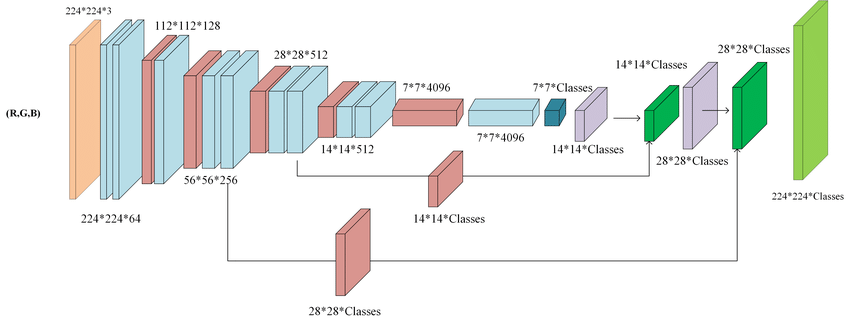

In [5]:
def make_fcn8(input_size = (224,224,3), drop_rate = 0.1):
  input = tf.keras.layers.Input(shape=input_size)
  
  feature_layers = [ vgg_16.get_layer('block3_conv3'), vgg_16.get_layer('block4_conv3'), vgg_16.get_layer('block5_conv3')]
  conv_extractor = tf.keras.models.Model(inputs = vgg_16.input, outputs = [layer.output for layer in feature_layers])
  #w = image width
  #conv_extractor returns list of [(w/4,w/4,256),(w/8,w/8,512),(w/16,w/16,512)] tensors

  """dont do this:
    b3c3_model = Model(inputs=vgg_model.input, outputs = vgg_model.get_layer('block3_conv3').output)
    b3c3_model.trainable=False

    b2c2_model = Model(inputs=vgg_model.input, outputs = vgg_model.get_layer('block2_conv2').output)
    b2c2_model.trainable=False

    b1c2_model = Model(inputs=vgg_model.input, outputs = vgg_model.get_layer('block1_conv2').output)
    b1c2_model.trainable=False"""

  regularizer = tf.keras.regularizers.L1(l1=1e-4)
  features = conv_extractor(input)
  
  x3 = features[0]
  x3 = tf.keras.layers.Dropout(0,name='features_c3')(x3)
  x3 = tf.keras.layers.MaxPool2D()(x3)
  x3 = tf.keras.layers.Conv2D(num_classes, kernel_size = 1, activation = 'relu', padding = 'same', kernel_regularizer=regularizer)(x3)
  x3 = tf.keras.layers.Dropout(drop_rate)(x3)
  #(w/4,w/4,num_classes)


  x4 = features[1] #w/8
  x4 = tf.keras.layers.Dropout(0,name='features_c4')(x4)
  x4 = tf.keras.layers.MaxPool2D()(x4)
  x4 = tf.keras.layers.Conv2D(num_classes, kernel_size = 1, activation = 'relu', padding = 'same',kernel_regularizer=regularizer)(x4)
  x4 = tf.keras.layers.Dropout(drop_rate)(x4)
  #(w/8,w/8,num_classes)

  x5 = features[2] #w/16
  x5 = tf.keras.layers.Dropout(0,name='features_c5')(x5)

  #block6
  x = tf.keras.layers.MaxPool2D()(x5)
  x = tf.keras.layers.Conv2D(4096, kernel_size = 7, activation = 'relu', padding='same', kernel_regularizer=regularizer)(x)
  #x = tf.keras.layers.Conv2D(4096, kernel_size = 1, activation = 'relu', padding='same')(x)
  x = tf.keras.layers.Dropout(drop_rate)(x)

  #block7
  x = tf.keras.layers.Conv2D(4096, kernel_size = 1, activation = 'relu', kernel_regularizer=regularizer)(x)
  x = tf.keras.layers.Dropout(drop_rate)(x)
  
  #block8
  x = tf.keras.layers.Conv2D(num_classes, kernel_size = 1, activation = None, kernel_regularizer=regularizer)(x)
  x = tf.keras.layers.Dropout(drop_rate)(x)
  #(w/16,w/16,num_classes)

  #decoder

  #upsample 1 + skip
  x = tf.keras.layers.Conv2DTranspose(num_classes, kernel_size = 4, strides= (2,2), padding='same', kernel_regularizer=regularizer)(x)
  x = x+x4
  x = tf.keras.layers.Dropout(drop_rate)(x)
  #upsample 2 + skip
  x = tf.keras.layers.Conv2DTranspose(num_classes, kernel_size = 4, strides= (2,2), padding='same', kernel_regularizer=regularizer)(x)
  x= x+x3
  x = tf.keras.layers.Dropout(drop_rate)(x)

  #upsample 3
  x = tf.keras.layers.Conv2DTranspose(num_classes, kernel_size = 16, strides= (8,8), padding='same', activation='softmax', kernel_regularizer=regularizer)(x) #softmax over axis = -1
  x = tf.keras.layers.Dropout(drop_rate)(x)




  

  #x = tf.keras.layers.Conv2D(filters = 4096, strides = (2,2))



  return tf.keras.models.Model(inputs = input, outputs = x)

In [6]:
test = make_fcn8()
test.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              [(None, 56, 56, 256) 14714688    input_2[0][0]                    
__________________________________________________________________________________________________
features_c5 (Dropout)           (None, 14, 14, 512)  0           model[0][2]                      
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 7, 7, 512)    0           features_c5[0][0]                
____________________________________________________________________________________________

In [7]:
feature_layers = [test.get_layer('features_c3'),test.get_layer('features_c4'),test.get_layer('features_c5')]
feature_extractor = tf.keras.models.Model(inputs = test.input, outputs = [layer.output for layer in feature_layers])
test_tensor = tf.random.normal((1,224,224,3))
features = feature_extractor(test_tensor)

for feature in features:
  print(feature.shape)

(1, 56, 56, 256)
(1, 28, 28, 512)
(1, 14, 14, 512)


In [8]:
shutil.unpack_archive("/content/drive/MyDrive/DeepGlobe_224.zip",'/content/DeepGlobe')

#Data Pipeline
Read as list dataset and write a function to split image vs label

https://www.kaggle.com/balraj98/deepglobe-land-cover-classification-dataset

##Label
Each satellite image is paired with a mask image for land cover annotation. The mask is a RGB image with 7 classes of labels, using color-coding (R, G, B) as follows.

Urban land: 0,255,255 - Man-made, built up areas with human artifacts (can ignore roads for now which is hard to label)

Agriculture land: 255,255,0 - Farms, any planned (i.e. regular) plantation, cropland, orchards, vineyards, nurseries, and ornamental horticultural areas; confined feeding operations.

Rangeland: 255,0,255 - Any non-forest, non-farm, green land, grass

Forest land: 0,255,0 - Any land with x% tree crown density plus clearcuts.

Water: 0,0,255 - Rivers, oceans, lakes, wetland, ponds.

Barren land: 255,255,255 - Mountain, land, rock, dessert, beach, no vegetation

Unknown: 0,0,0 - Clouds and others

File names for satellite images and the corresponding mask image are id _sat.jpg and id _mask.png. id is a randomized integer.

Please note:

The values of the mask image may not be pure 0 and 255. When converting to labels, please binarize them at threshold 128.

##Testing/Rough draft

In [9]:
data_dir = "/content/DeepGlobe"
list_ds = tf.data.Dataset.list_files(str(data_dir+"/*_sat.jpg"),shuffle=False) #DO NOT SHUFFLE
#dataset is made up of strings

In [10]:
for f in list_ds.take(4):
  print(f.numpy())

b'/content/DeepGlobe/100694_0_sat.jpg'
b'/content/DeepGlobe/100694_10_sat.jpg'
b'/content/DeepGlobe/100694_11_sat.jpg'
b'/content/DeepGlobe/100694_12_sat.jpg'


In [11]:
class_dict = {(25.5+2.55):1, (255+25.5):2, (255+2.55):3,(25.5):4,2.55:5,(255+25.5+2.55):6,0:0}
def to_categorical(tensor,class_dict):
  for k,v in class_dict.items():
    tensor[tensor==k]=v
  return tensor

##dataset functions

In [12]:
image = tf.keras.preprocessing.image.load_img(b'/content/DeepGlobe/100694_10_sat.jpg')
image = tf.keras.preprocessing.image.img_to_array(image)

label = tf.keras.preprocessing.image.load_img(b'/content/DeepGlobe/100694_10_mask.jpg')
label = tf.keras.preprocessing.image.img_to_array(label) 

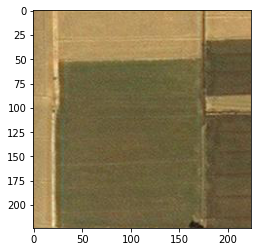

In [13]:
plt.imshow(image/255)

In [14]:
def get_item(path):
  #wrap function in tf.numpy_function() or tf.data.dataset.map bugs out
  def _get_item(path):
    """
    args:
    path:str - image path

    returns: 
    (h,w,3),(h,w,1) image-label pair
    """
    fn = tf.strings.split(path,"_")
    #image_fn = tf.strings.join([fn[0],"_sat.jpg"])
    #label_fn = tf.strings.join([fn[0],"_mask.png"])
    image_fn = (fn[0]+"_"+fn[1]+"_sat.jpg").numpy()
    label_fn = (fn[0]+"_"+fn[1]+"_mask.jpg").numpy()


  
  

    image = tf.keras.preprocessing.image.load_img(image_fn)
    image = tf.keras.preprocessing.image.img_to_array(image)

    label = tf.keras.preprocessing.image.load_img(label_fn)
    label = tf.keras.preprocessing.image.img_to_array(label)

    label [label >= 128] = 255
    label[label < 128] = 0
    #(h,w,3)

    labelnew = label[:,:,0]+0.1*label[:,:,1]+0.01*label[:,:,2]
    class_dict = {(25.5+2.55):0, (255+25.5):1, (255+2.55):2,(25.5):3,2.55:4,(255+25.5+2.55):5,0:6}
    labelnew = to_categorical(labelnew,class_dict)

    labelnew = tf.expand_dims(labelnew,axis=-1)
    #(h,w,1) tensor of int from 1-6

    return image,labelnew

  output = tf.numpy_function(_get_item,[path],[tf.float32,tf.float32])

  return output

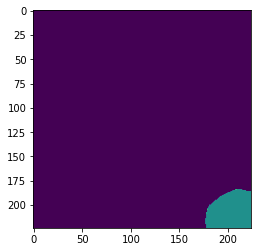

In [15]:
#Test
image,label = get_item('/content/DeepGlobe/200561_50_mask.jpg')

plt.imshow(label[:,:,0])

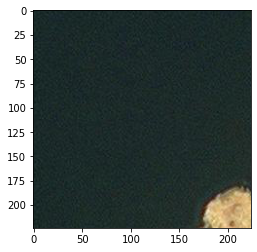

In [16]:
plt.imshow(image/255)

In [17]:
np.unique(label) #water,barren and forest

array([4., 5., 6.], dtype=float32)

In [18]:
train_ds = list_ds.map(get_item,num_parallel_calls=tf.data.AUTOTUNE)
for f in train_ds.take(2):
  print(f[0].shape,f[1].shape)
  test_data = f

(224, 224, 3) (224, 224, 1)
(224, 224, 3) (224, 224, 1)


In [19]:
train_ds = train_ds.batch(32)
test_ds = train_ds.take(1)

In [20]:
prediction = test.predict(test_ds)
prediction.shape

(32, 224, 224, 7)

In [21]:
test.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['mae'])

##Testing over

In [22]:
data_dir = "/content/DeepGlobe"
list_ds = tf.data.Dataset.list_files(str(data_dir+"/*_sat.jpg"),shuffle=False) #DO NOT SHUFFLE
#dataset is made up of strings

In [47]:
def preprocessing(list_ds,batch_size=32,augmentation=None):
  ds = list_ds.map(get_item,num_parallel_calls=tf.data.AUTOTUNE) #(h,w,3),(h,w,1)
  ds = ds.shuffle(100)

  ds = ds.cache()
  if augmentation:
    ds = ds.map((lambda x,y : augmentation(x,y)),num_parallel_calls=tf.data.AUTOTUNE)

  ds = ds.batch(batch_size)
  ds = ds.prefetch(8)
  return ds

def transform(x,y):
  """
  Write your data transformations here
  """
  x=tf.keras.layers.experimental.preprocessing.Rescaling(1./255.0)(x)
  y=tf.one_hot(tf.cast(y[:,:,0],dtype = tf.int32),depth = 7)

  return x,y

In [48]:
ds = preprocessing(list_ds,augmentation=transform)

In [49]:
a=list(ds.take(1))

In [50]:
test.fit(ds,epochs=2,verbose=1)

Epoch 1/2
  23/2510 [..............................] - ETA: 52:18 - loss: nan - mae: nan

KeyboardInterrupt: ignored